In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)
%matplotlib inline

import sys
import os
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import data, io
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from tensorflow.keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load the label file

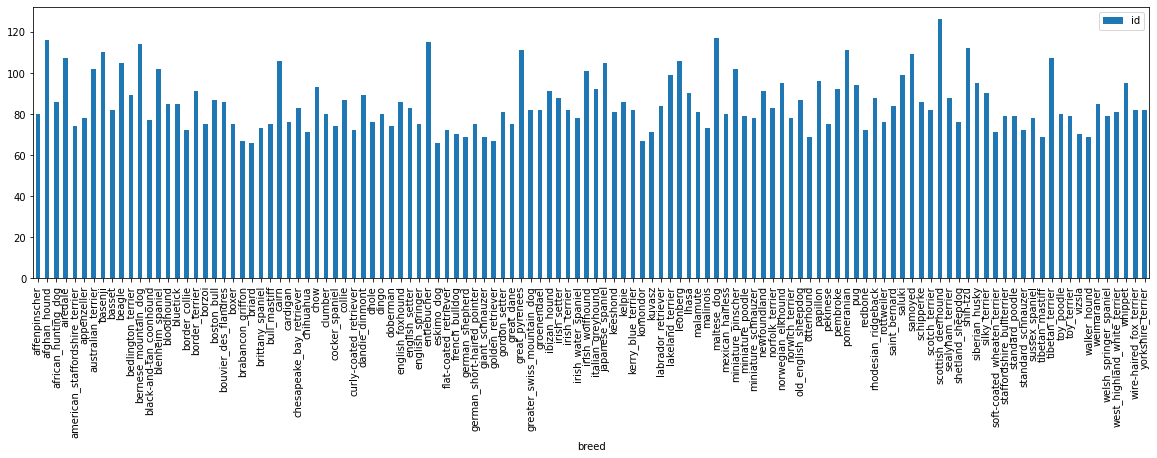

In [ ]:
#read ordered labels from CSV file 
labels = pd.read_csv("/content/drive/Shared drives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/labels.csv")
coun = labels.groupby('breed').count()
coun.plot(kind = 'bar', figsize = (20, 5))

#### Identify 20 different breeds with 100 images or above

In [ ]:
# Find 20 categories with 100 image or above
img100 = coun['id'].sort_values(ascending = False)[0:20]
img100_idx = img100.index.sort_values()
print("Total images number of 20 categories with 100 images or above:\n", img100.sum())
print("\n 20 categories with 100 images or above:\n", img100_idx)

Total images number of 20 categories with 100 images or above:
 2184

 20 categories with 100 images or above:
 Index(['afghan_hound', 'airedale', 'australian_terrier', 'basenji', 'beagle',
       'bernese_mountain_dog', 'blenheim_spaniel', 'cairn', 'entlebucher',
       'great_pyrenees', 'irish_wolfhound', 'japanese_spaniel', 'leonberg',
       'maltese_dog', 'miniature_pinscher', 'pomeranian', 'samoyed',
       'scottish_deerhound', 'shih-tzu', 'tibetan_terrier'],
      dtype='object', name='breed')


In [ ]:
# Identify the filenames for these 20 categories
sub_data = labels[labels['breed'].isin(img100_idx)]
img100_id = sub_data['id']
print(sub_data.head())

                                  id               breed
8   003df8b8a8b05244b1d920bb6cf451f9             basenji
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
12  00693b8bc2470375cc744a6391d397ec         maltese_dog
29  00bee065dcec471f26394855c5c2f3de               cairn
48  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier


In [ ]:
# Create a list containing all the selected files and their directories
path = '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/'
img100_files = [path+i+'.jpg' for i in img100_id]
img100_files[0:5]

['/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/00693b8bc2470375cc744a6391d397ec.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/00bee065dcec471f26394855c5c2f3de.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg']


#### Load images

In [ ]:
# Load images
imgs = []
for pic in img100_files[0:]:
  img = io.imread(pic)
  imgs.append(img)

images = np.asarray(imgs)

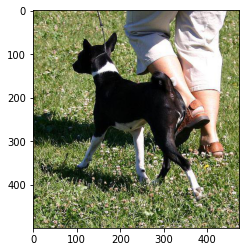

In [ ]:
plt.imshow(images[0])

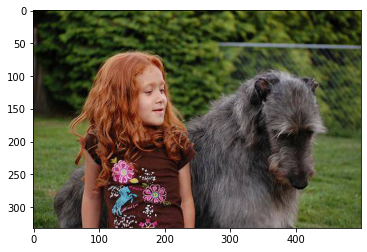

In [ ]:
plt.imshow(images[1])

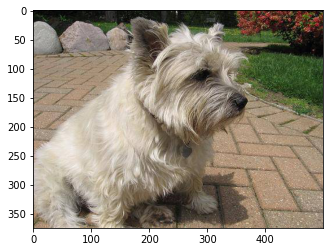

In [ ]:
plt.imshow(images[3])

#### Resize the images and prepare for model

In [ ]:
# Find the resize shape (we have to resize all images to the smallest image dims in the file )
IMG_RDIM = min([images[j].shape[0] for j in range(images.shape[0])])
IMG_CDIM = min([images[k].shape[1] for k in range(images.shape[0])])
IMG_RGB = min([images[l].shape[2] for l in range(images.shape[0])])
print(IMG_RDIM, IMG_CDIM, IMG_RGB)

IMG_DIM = min(IMG_RDIM, IMG_CDIM)
print(IMG_DIM)

103 97 3
97


In [ ]:
# Resize the shape and prepare data for model 
images_resized = []

for i in images:
  img_resized = resize(i, (224, 224,IMG_RGB))
  images_resized.append(img_resized)

images_resized = np.asarray(images_resized)

In [ ]:
images_resized.shape

(2184, 224, 224, 3)

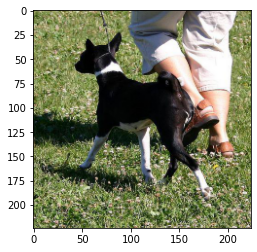

In [ ]:
plt.imshow(images_resized[0])

#### Prepare labels data for model

In [ ]:
# Prepare labels data for model
# We can use sub_data['breed] for labels. However in order to make sure the filenames and the breed are matched, we will cross check this.

# Get the filenames for photoes in img100_files
import os
files = []
for pic in img100_files[0:]:
  base = os.path.basename(pic)
  filename = os.path.splitext(base)[0]
  files.append(filename)

df_files = pd.DataFrame(files, columns = ['id'])

In [ ]:
# Get the breed information based on the filenames
df_labels = df_files.merge(labels, how = 'left', on = 'id')
df_labels.shape

(2184, 2)

#### Train test split, normalization, and generate rotated images

In [ ]:
# Split train and test
X = images_resized
y = df_labels['breed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X.shape, y.shape)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2184, 224, 224, 3) (2184,)
(1528, 224, 224, 3) (656, 224, 224, 3)
(1528,) (656,)


In [ ]:
# input image dimensions
img_rows, img_cols = 224, 224

#X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
#X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

#normalize pixel intensities
#X_train /= 255
#X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (1528, 224, 224, 3)
1528 train samples
656 test samples


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#test_labels = y_test

# Create binarized labels for training
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')
y_train[0]

(1528, 20) train labels
(656, 20) test labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

#### Model: Build CNN from scratch

In [ ]:
# Build CNN, using Keras Sequential API
model2 = Sequential()
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape  = input_shape))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(256, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(20, activation='softmax'))

In [ ]:
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

In [ ]:
history1 = model2.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/100
48/47 [==============================] - 4s 88ms/step - loss: 2.7174 - accuracy: 0.1505 - val_loss: 3.2543 - val_accuracy: 0.0716
Epoch 2/100
48/47 [==============================] - 4s 87ms/step - loss: 2.6660 - accuracy: 0.1610 - val_loss: 3.0962 - val_accuracy: 0.0732
Epoch 3/100
48/47 [==============================] - 4s 87ms/step - loss: 2.6072 - accuracy: 0.1630 - val_loss: 3.0180 - val_accuracy: 0.0976
Epoch 4/100
48/47 [==============================] - 4s 86ms/step - loss: 2.6499 - accuracy: 0.1728 - val_loss: 2.8190 - val_accuracy: 0.1387
Epoch 5/100
48/47 [==============================] - 4s 87ms/step - loss: 2.6379 - accuracy: 0.1898 - val_loss: 2.6148 - val_accuracy: 0.1997
Epoch 6/100
48/47 [==============================] - 4s 86ms/step - loss: 2.5838 - accuracy: 0.1813 - val_loss: 2.5312 - val_accuracy: 0.2210
Epoch 7/100
48/47 [==============================] - 4s 86ms/step - loss: 2.5674 - accuracy: 0.1924 - val_loss: 2.4961 - val_accuracy: 0.2271
Epoch 

#### Model - Use Resnet152V2

In [ ]:
from keras import applications

In [ ]:
modelR152V2 = applications.ResNet152V2(weights = "imagenet", include_top=False, input_shape =  input_shape)

In [ ]:
# Freeze the layers which you don't want to train. 
for layer in modelR152V2.layers[:50]:
    layer.trainable = False

#Adding custom Layers 
x = modelR152V2 .output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(20, activation="softmax")(x)

# creating the final model 
model_final_R152V2 = Model(inputs = modelR152V2.input, outputs = predictions)

In [ ]:
model_final_R152V2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
epochs = 300
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

In [ ]:
history_R152V2 = model_final_R152V2.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))#, callbacks=[es])

Epoch 1/300
48/47 [==============================] - 40s 825ms/step - loss: 3.7648 - accuracy: 0.0582 - val_loss: 316188882108416.0000 - val_accuracy: 0.0381
Epoch 2/300
48/47 [==============================] - 37s 771ms/step - loss: 3.0852 - accuracy: 0.0484 - val_loss: 95248.8906 - val_accuracy: 0.0427
Epoch 3/300
48/47 [==============================] - 38s 794ms/step - loss: 3.0157 - accuracy: 0.0589 - val_loss: 649.6188 - val_accuracy: 0.0732
Epoch 4/300
48/47 [==============================] - 40s 828ms/step - loss: 3.1205 - accuracy: 0.0543 - val_loss: 2.9997 - val_accuracy: 0.0473
Epoch 5/300
48/47 [==============================] - 40s 828ms/step - loss: 3.0524 - accuracy: 0.0556 - val_loss: 3.0001 - val_accuracy: 0.0290
Epoch 6/300
48/47 [==============================] - 40s 831ms/step - loss: 3.0560 - accuracy: 0.0510 - val_loss: 40.4333 - val_accuracy: 0.0381
Epoch 7/300
48/47 [==============================] - 40s 835ms/step - loss: 3.1236 - accuracy: 0.0589 - val_loss: 4

Text(0.5, 1.0, 'Accuracy Curves ResNet150V2 X_Train Rotated 224X224')

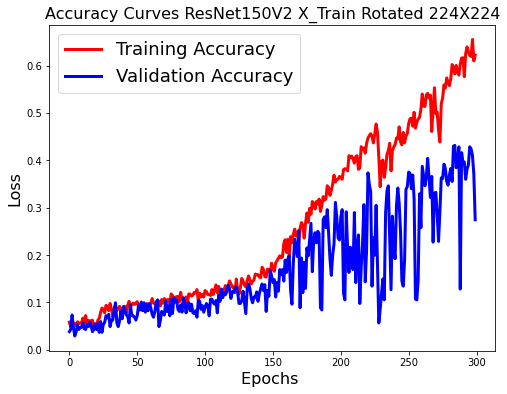

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history_R152V2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_R152V2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Accuracy Curves ResNet150V2 X_Train Rotated 224X224',fontsize=16)